# Optimisation of a wrapped composite barrel
This notebook solves the problem of finding the optimal lamination sequence of a cylinder with a steel liner and a composite wrapped reinforcement to be used as gun barrel replacing the Reihnmetall 120 L/44.
Details are available in the slides.

The scheme of the cylinder is shown in Figure 1

![clynder](wrapped_barrel_scheme.png "Problem description")

 <div align="center">
  Figure 1: Problem description. Drawing not to scale.
</div> 

The bounds on the design space $\mathcal{A}$ are given by:
$$
        \begin{aligned}
            %line 1
            8 \leq h_s \leq 35 \qquad & 12.5 \leq h_a < 50\\
            %line 2
            15^\circ \leq \phi_a \leq 55^\circ 
            \qquad & 1400 \leq X_b \leq 5000
        \end{aligned}
$$


In [1]:
#IMPORTS
%matplotlib inline 
import numpy as np
import matplotlib.pylab as plt
import pyOpt
from scipy.interpolate import Rbf
#globals
BASE_PLOT_WIDTH=14
BASE_PLOT_HEIGHT=4
NVAR = 4#the number of variables in the design space
NS = 7 #the number of samples used
DSTAR = 490 #steel bending stiffnes
X_S = 5280.0 #lenght of the steel region
X_C = 1200.0 #lenght of the region c
R_i = 60.0 #internal half calibre
H_C = 10.0#thickness of region c
RHO_STEEL = 7800.0e-9

In [2]:
def plotVaryPhiFixedX_b(XG,YG,ZG,angles,length,func,name,level=1.0,unit=''):
    """
    Utility function to plot an objective/constraint  
    function at varying h_a, h_s, for all the sampled angles at fixed value of X_b
    
    Parameters
    -----------
    XG: nd.array
        the gridded data for h_s (plt.contourf must be able to understand it).
        
    YG: nd.array
        the gridded data for h_a.
        
    ZG: nd.array
        an array of the same shape as XG.
        
    angles: nd.array, shape ns
        the array of angles to evaluate.
        
    length: float
        the value of X_b to use.
        
    func: scipy Rbf
        the interpolating function.
    
    name: string
        a sting representing the name of the interpolating function.
    
    level: float, optional
        a contour level to be diplayed by a thick red line. Defaults to 1.0.
        
    unit: string, optional
        the unit of measurment of func. Defualts to an empty string.
    
    """
    npoints = XG.shape[0]
    ns = len(angles)
    figure=plt.figure(figsize=(BASE_PLOT_WIDTH, BASE_PLOT_HEIGHT*ns))
    for p,angle in enumerate(angles):
        for i in range(npoints):
            for j in range(npoints):
                ZG[i,j] = func(XG[i,j],YG[i,j],angle,length)
        plt.subplot(ns/2+ns%2,2,p+1)
        plt.contourf(XG,YG,ZG)
        cb = plt.colorbar()
        cb.ax.tick_params(labelsize='x-large')
        plt.contour(XG,YG,ZG,[level],colors=('r',), linewidth=6)#line at level 1, failure locus
        plt.xlabel('$h_s$, normalised [-]', fontsize='xx-large')
        plt.ylabel('$h_a$, normalised [-]', fontsize='xx-large')
        plt.xticks (fontsize='x-large')
        plt.yticks(fontsize='x-large')
        title = '$'+name+'$ ['+ unit +'] for X_b='+"{:.1f}".format(length)+' and $\phi_a$='+"{:.1f}".format(angle)
        plt.title(title, fontsize='xx-large',y=1.05)
    plt.tight_layout()

def norminp(data):
    """
    Utility function to normalize the input data in range [0,1]
    
    Paramters
    ----------
    data: 1d array
        the input data
    
    Returns
    ----------
    result: 1d array
        the normalised array
        
    """
    
    return (data-np.min(data))/(np.max(data)-np.min(data))

Select the data set, by evaluating one of these two cells

In [3]:
#carbon
data = np.genfromtxt('wrapped_barrel_obj_carbon.txt', names=True)
rho = 1580.0e-9
resfile = 'wrapped_barrel_opt_params_carbon.txt'
matname = 'carbon'

In [3]:
#SiC/Ti
data = np.genfromtxt('wrapped_barrel_obj_sic.txt', names=True)
rho = 4207.0e-9
resfile = 'wrapped_barrel_opt_params_sic.txt'
matname = 'sic'

Since the physical quanties involved have very different units and span over different lenghts, we normalize the coordinates in the design space so that they vary in $[0,1]$. This is important because the basis functions $\omega(r)=\exp(-r^2/\epsilon^2)$ with $r=\lVert \mathbf{u}-\mathbf{u}_k\rVert$ have a single support size $\epsilon$ which is usually selected to be close to half the nodal spacing; if nodal spacing in different dimensions of the design space $\mathcal{A}$ is the risk is to have a resulting interpolation, in some dimensions, which is just a set of spikes connected by regions with constant zero value (in this problem, this would be the case for $X_b$).

In [4]:
#create interpolating data of the objective functions without smoothing, with gaussian basis
F_s = Rbf(norminp(data['h_s']),
          norminp(data['h_a']),
          norminp(data['phi_a']),
          norminp(data['X_b']),
          data['F_s'], function='gaussian')
F_c = Rbf(norminp(data['h_s']),
          norminp(data['h_a']),
          norminp(data['phi_a']),
          norminp(data['X_b']),data['F_c'], function='gaussian')
F_i = Rbf(norminp(data['h_s']),
          norminp(data['h_a']),
          norminp(data['phi_a']),
          norminp(data['X_b']),
          data['F_i'], function='gaussian')
bstiff = Rbf(norminp(data['h_s']),
              norminp(data['h_a']),
              norminp(data['phi_a']),
              norminp(data['X_b']),
            data['D'], function='gaussian')
#utility values to recover actual design space variables data
maxh_s = np.max(data['h_s'])
maxh_a = np.max(data['h_a'])
maxphi_a = np.max(data['phi_a'])
maxX_b = np.max(data['X_b'])
minh_s = np.min(data['h_s'])
minh_a = np.min(data['h_a'])
minphi_a = np.min(data['phi_a'])
minX_b = np.min(data['X_b'])

## Exploration of the design space
We draw some graphs to visualise the design space
### $F_s$ visualisation
The steel region failure criterion. For the Carbon/PEEK material this is the most critical of the failure criteria.

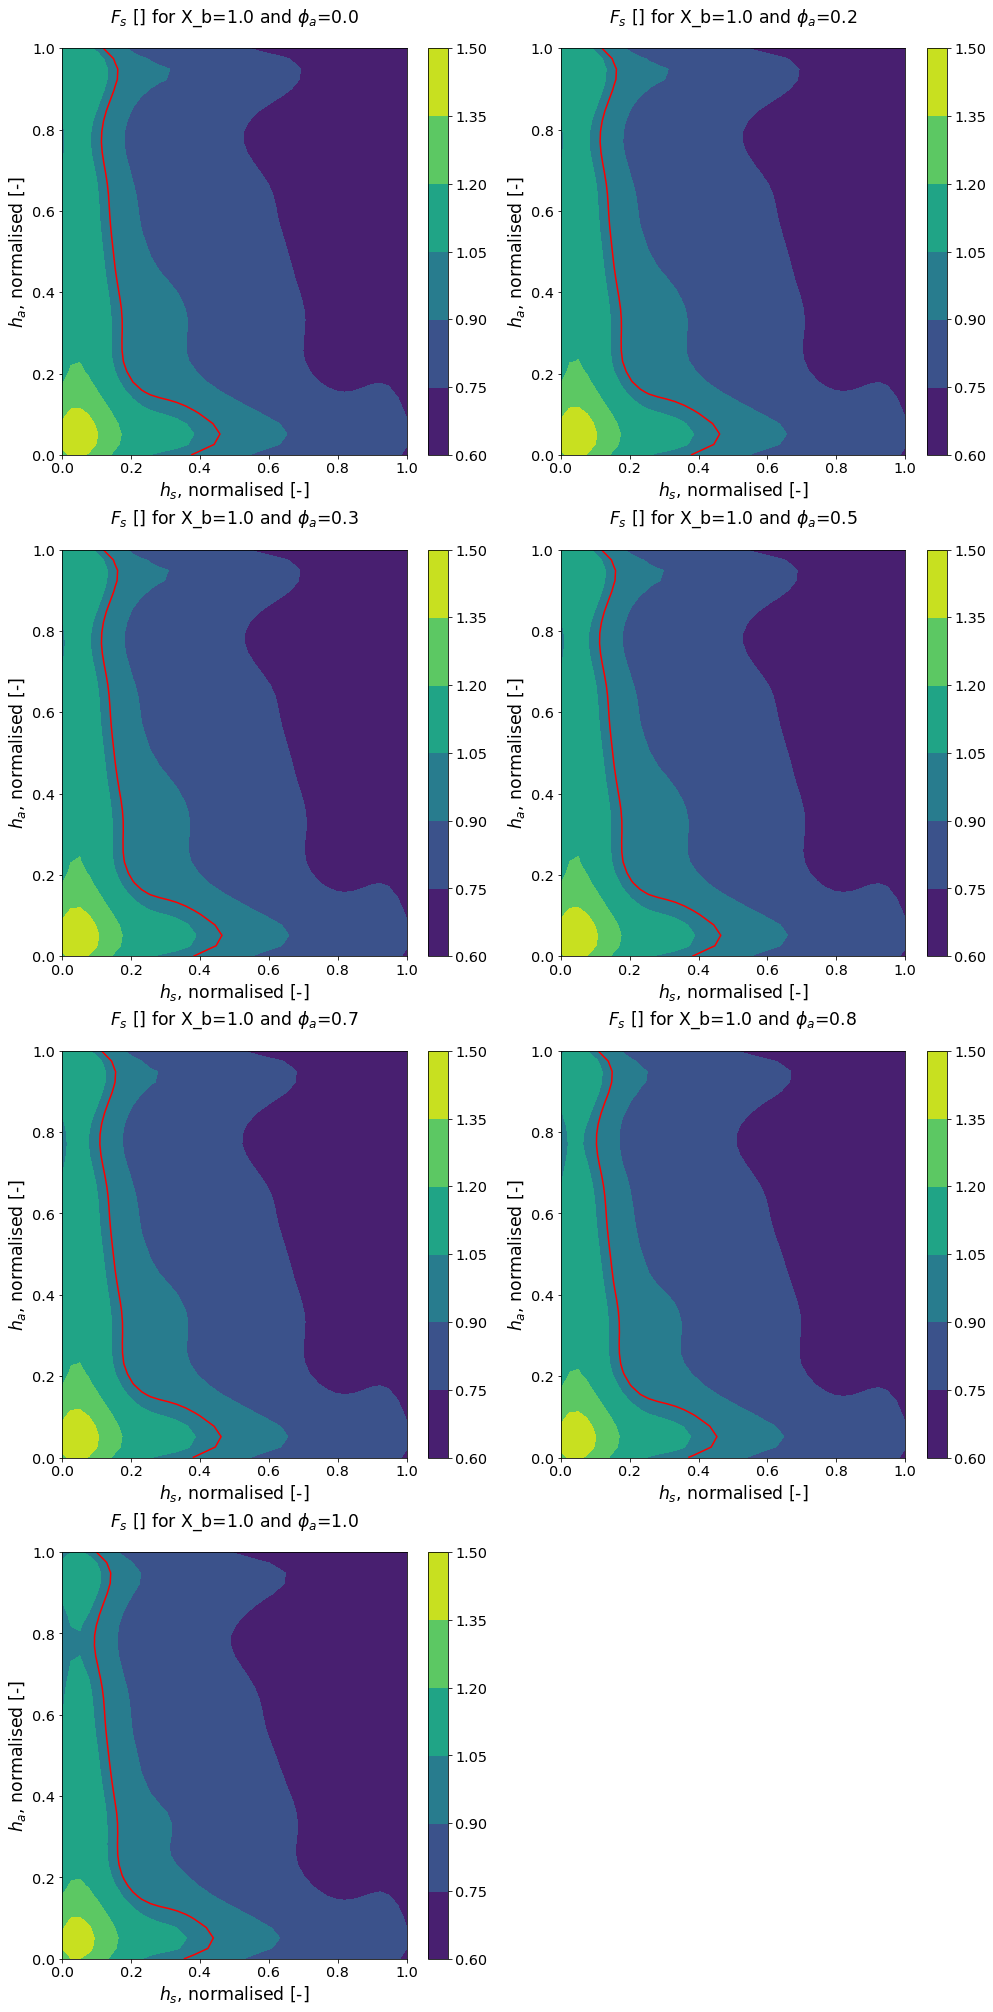

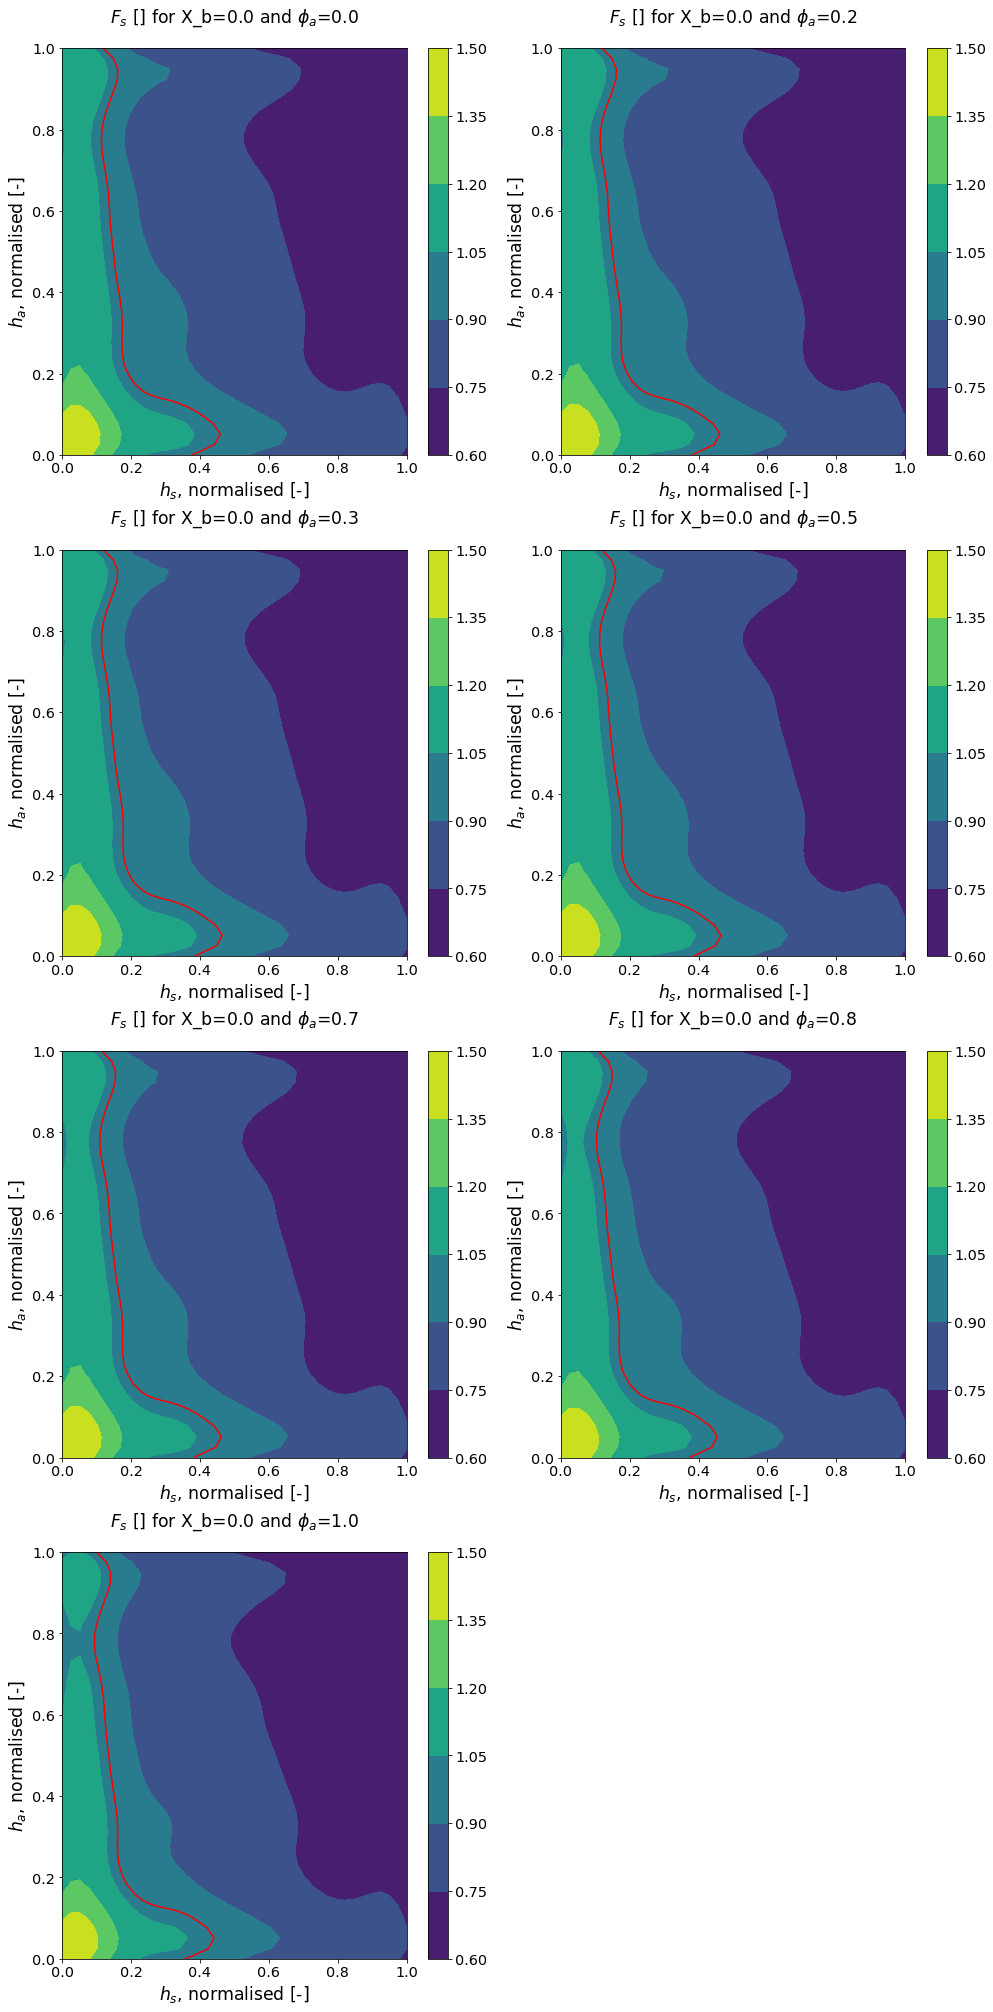

In [5]:
#define some auxiliary data
#define the points were the interpolated functions will be evaluated
npoints = 40
xpts = np.linspace(0,1,num=npoints)
ypts = np.linspace(0,1,num=npoints)
lengths = norminp(np.unique(data['X_b']))
lengths.sort()
angles = norminp(np.unique(data['phi_a']))
angles.sort()
#gridded data are needed by the contour plotting routines, while rbf wants simple arrays
XG , YG = np.meshgrid(xpts,ypts)
ZG = np.zeros_like(XG)
#we plot Fs at fixed values of maximum X_b[ns] and varying the value of phi
plotVaryPhiFixedX_b(XG,YG,ZG,angles,lengths[-1],F_s,'F_s')
#we plot Fs at fixed values of minimum X_b[ns] and varying the value of phi
plotVaryPhiFixedX_b(XG,YG,ZG,angles,lengths[0],F_s,'F_s')

$F_s$ is insenstitive to $\phi_a$, since we selected optimal thicknesses to resist pressure loads

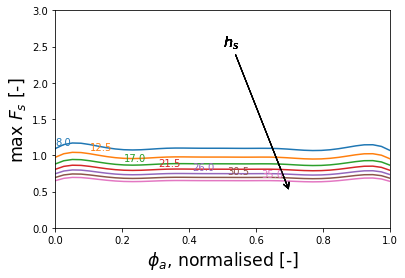

In [6]:
for k,ts in enumerate(norminp(np.unique(data['h_s']))):
    f = [F_s(ts,0.5,i,0.5) for i in xpts]
    line, = plt.plot(xpts,f)
    plt.text(xpts[4*k],f[4*k]+0.05,ts*(maxh_s-minh_s)+minh_s, color=line.get_color())
    plt.xlabel('$\phi_a$, normalised [-]', fontsize='xx-large')
    plt.ylabel('max $F_s$ [-]', fontsize='xx-large')
    plt.ylim(0,3)
    plt.xlim(0,1)
    plt.annotate('$h_s$',xy=(0.7, 0.5), xytext=(0.5, 2.5),color='k',fontsize='x-large',
            arrowprops=dict(arrowstyle="->",color='k'))

Itis also totally insensitive to $X_b$, since it basically depends only on the situation in a region close to $X=0$. Plot for  $h_a$ = 0.25 (normalised)

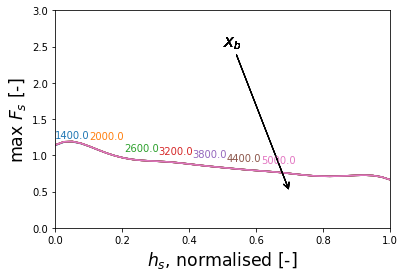

In [7]:
for k,lb in enumerate(norminp(np.unique(data['X_b']))):
    f = [F_s(i,0.25,0.0,lb) for i in xpts]
    line, = plt.plot(xpts,f)
    plt.text(xpts[4*k],f[4*k]+0.1,lb*(maxX_b-minX_b)+minX_b, color=line.get_color())
    plt.xlabel('$h_s$, normalised [-]', fontsize='xx-large')
    plt.ylabel('max $F_s$ [-]', fontsize='xx-large')
    plt.ylim(0,3)
    plt.xlim(0,1)
    plt.annotate('$X_b$',xy=(0.7, 0.5), xytext=(0.5, 2.5),color='k',fontsize='x-large',
            arrowprops=dict(arrowstyle="->",color='k'))

### $F_i$ visualisation
Interlaminar failure criterion

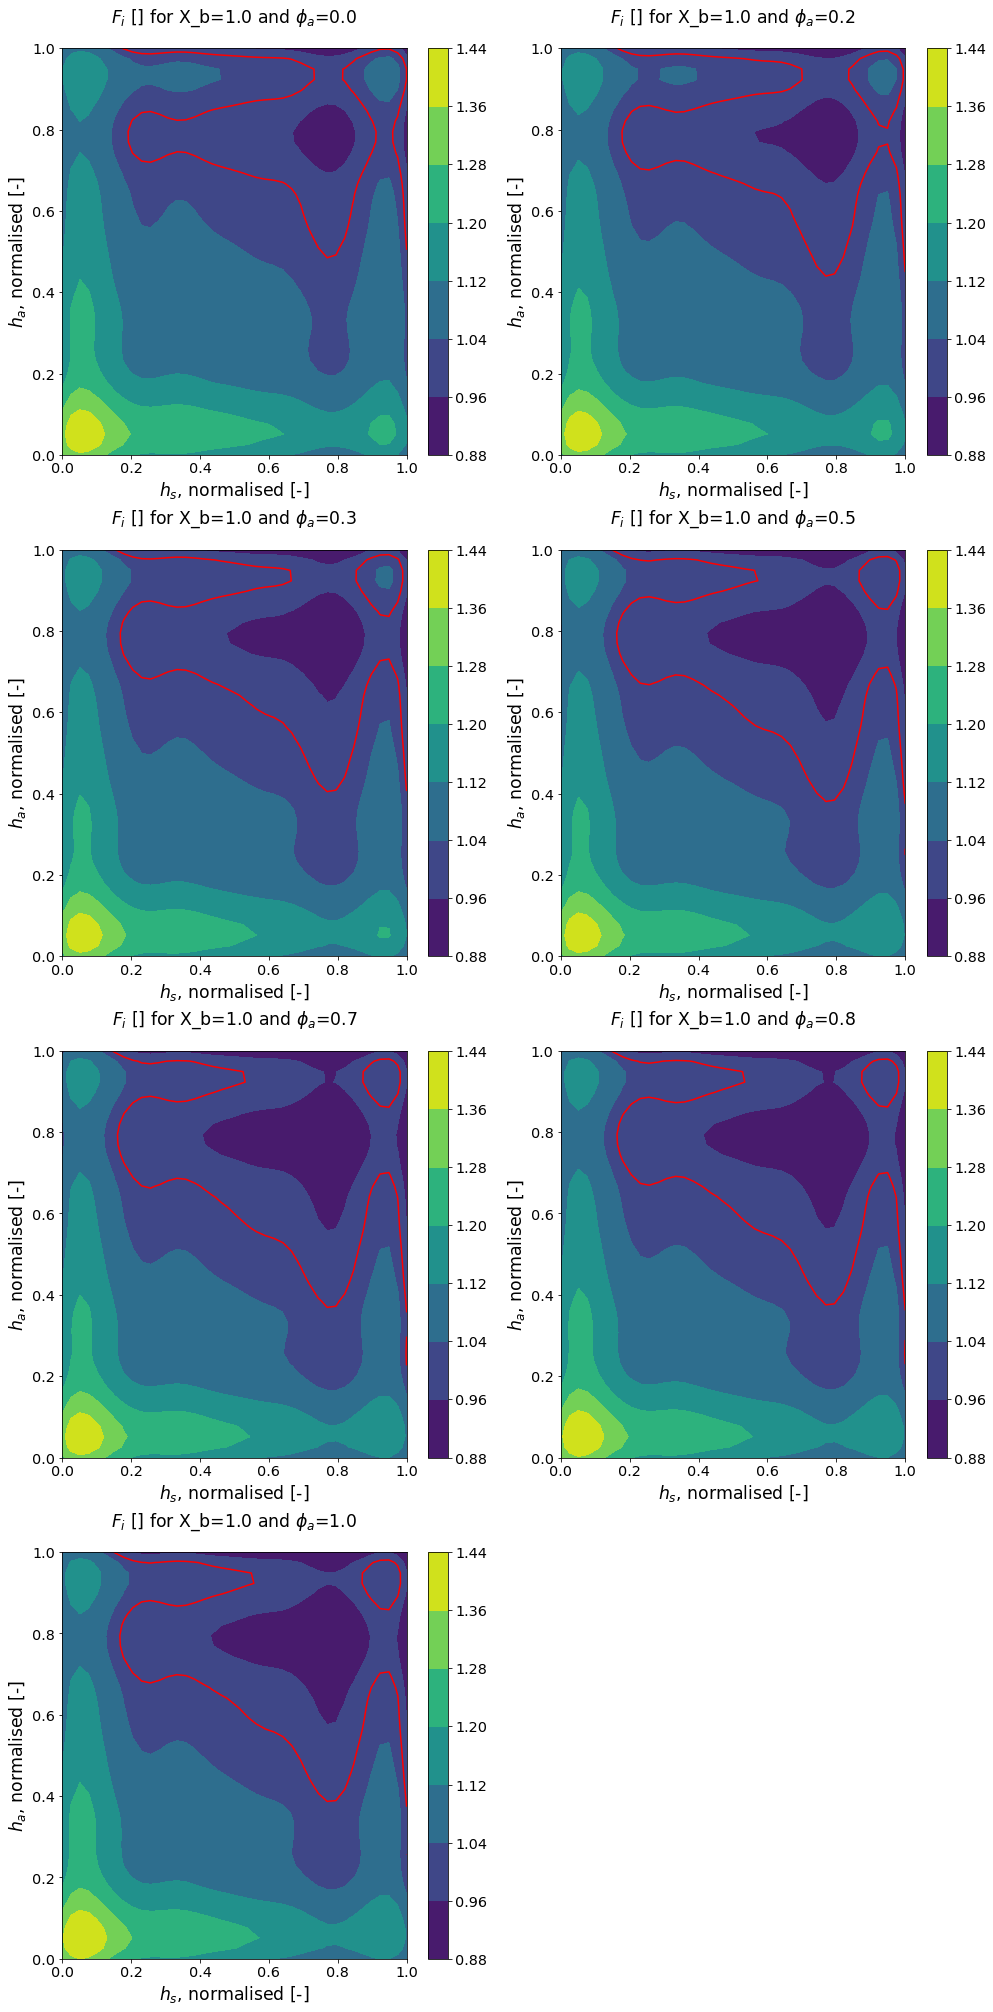

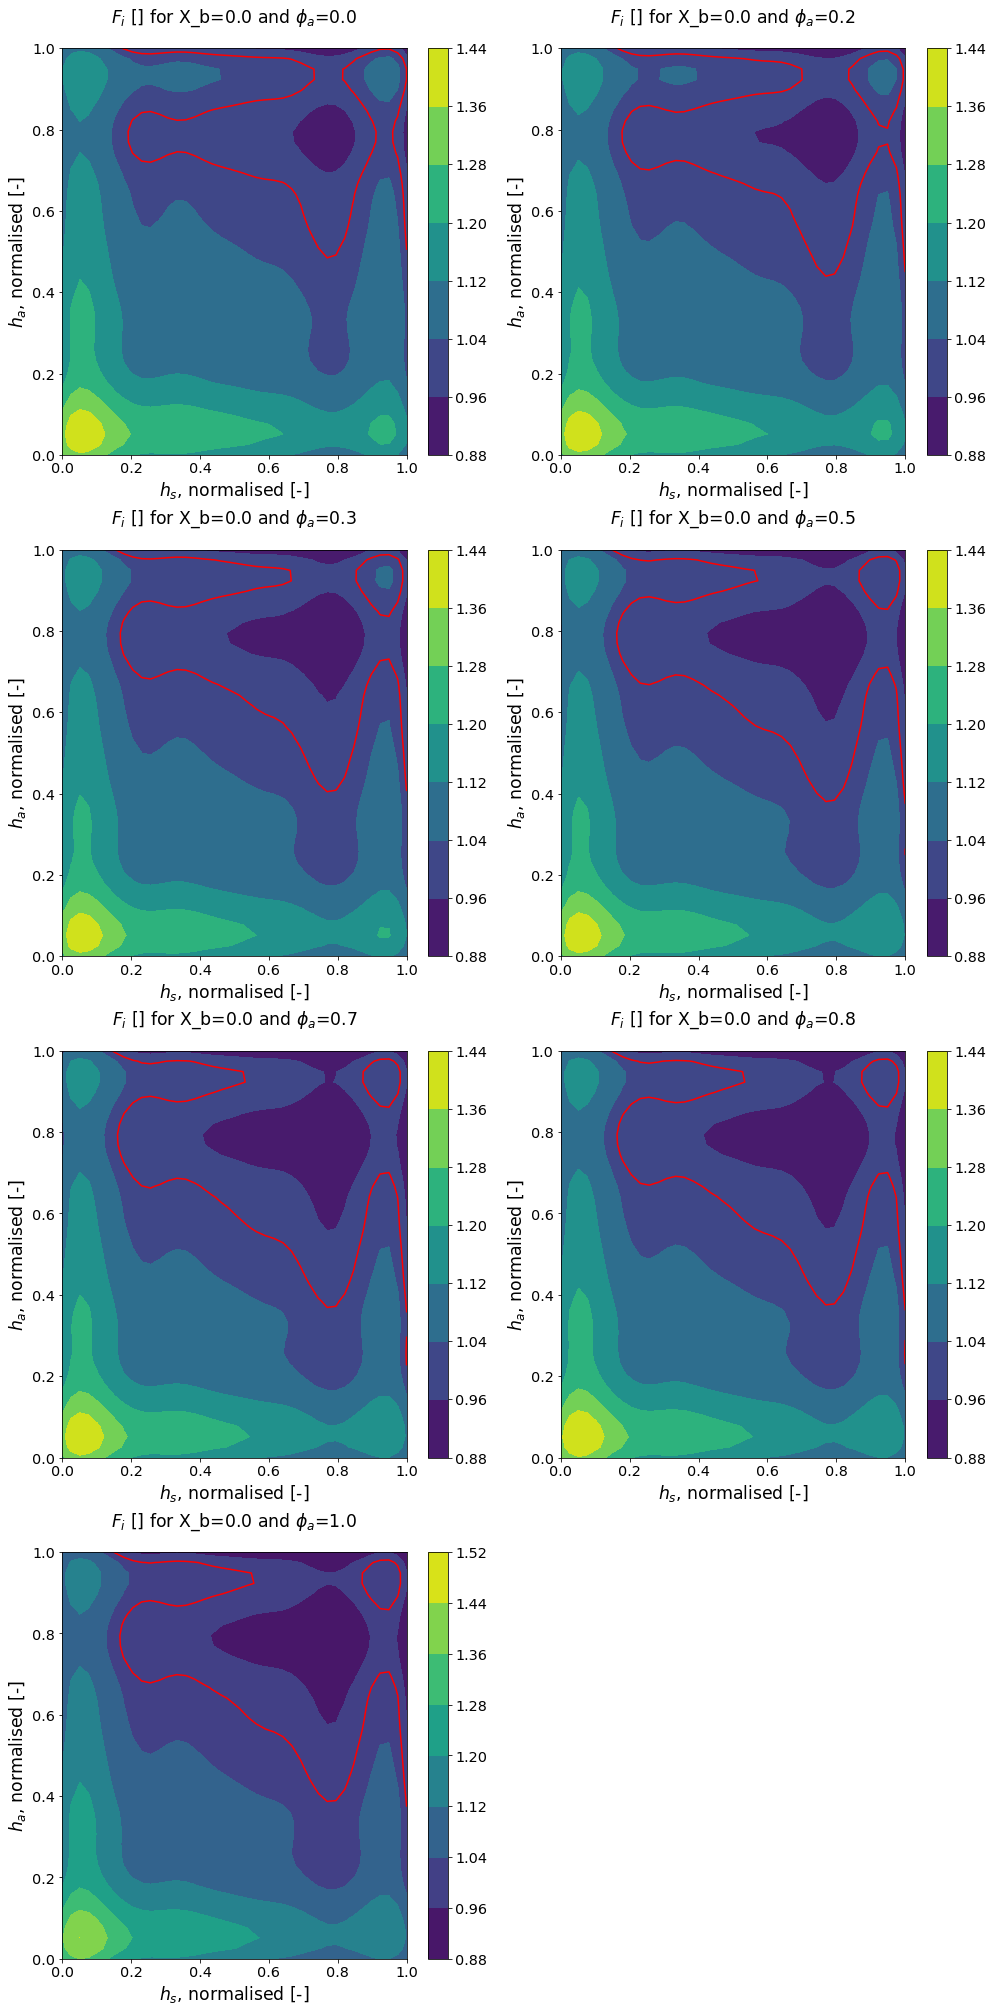

In [8]:
#we plot Fi at fixed values of maximum X_b[ns] and varying the value of phi
plotVaryPhiFixedX_b(XG,YG,ZG,angles,lengths[-1],F_i,'F_i')
#we plot Fi at fixed values of minimum X_b[ns] and varying the value of phi
plotVaryPhiFixedX_b(XG,YG,ZG,angles,lengths[0],F_i,'F_i')

Small variability of $F_i$ with respect to $X_b$, especially for low angles. Plot for $h_s$=0.7 and $h_a$=0.2 (normalised).

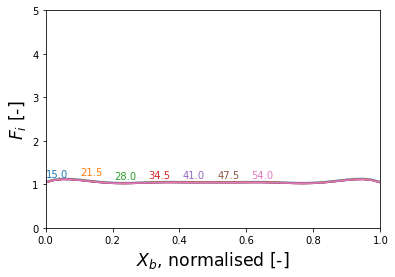

In [9]:
for k,angle in enumerate(angles):
    f = [F_i(0.7,0.2,angle,i) for i in xpts]
    line, = plt.plot(xpts,f)
    plt.text(xpts[4*k],f[4*k]+0.1,angle*(maxphi_a-minphi_a)+minphi_a, color=line.get_color())
    plt.xlabel('$X_b$, normalised [-]', fontsize='xx-large')
    plt.ylabel('$F_i$ [-]', fontsize='xx-large')
    plt.ylim(0,5)
    plt.xlim(0,1)

### $F_c$ visualisation
Composite in-plane failure (Tsai-Wu)

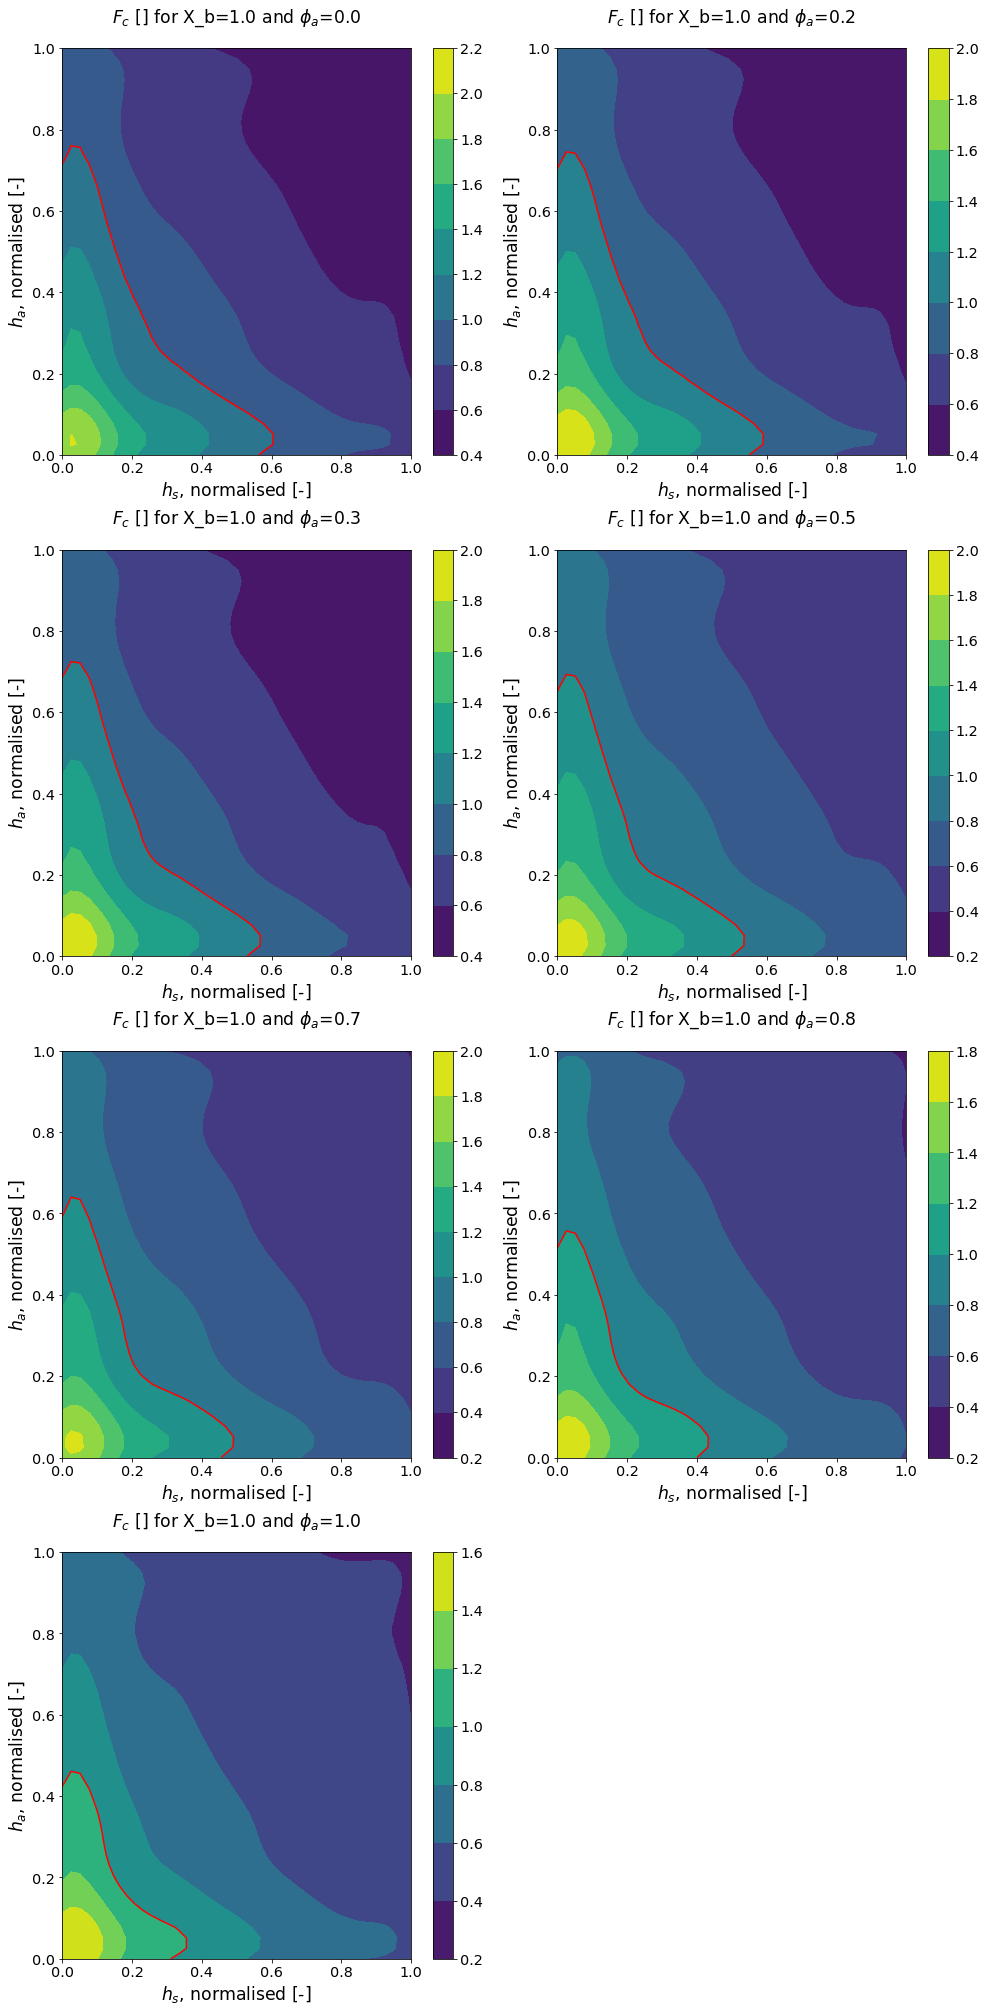

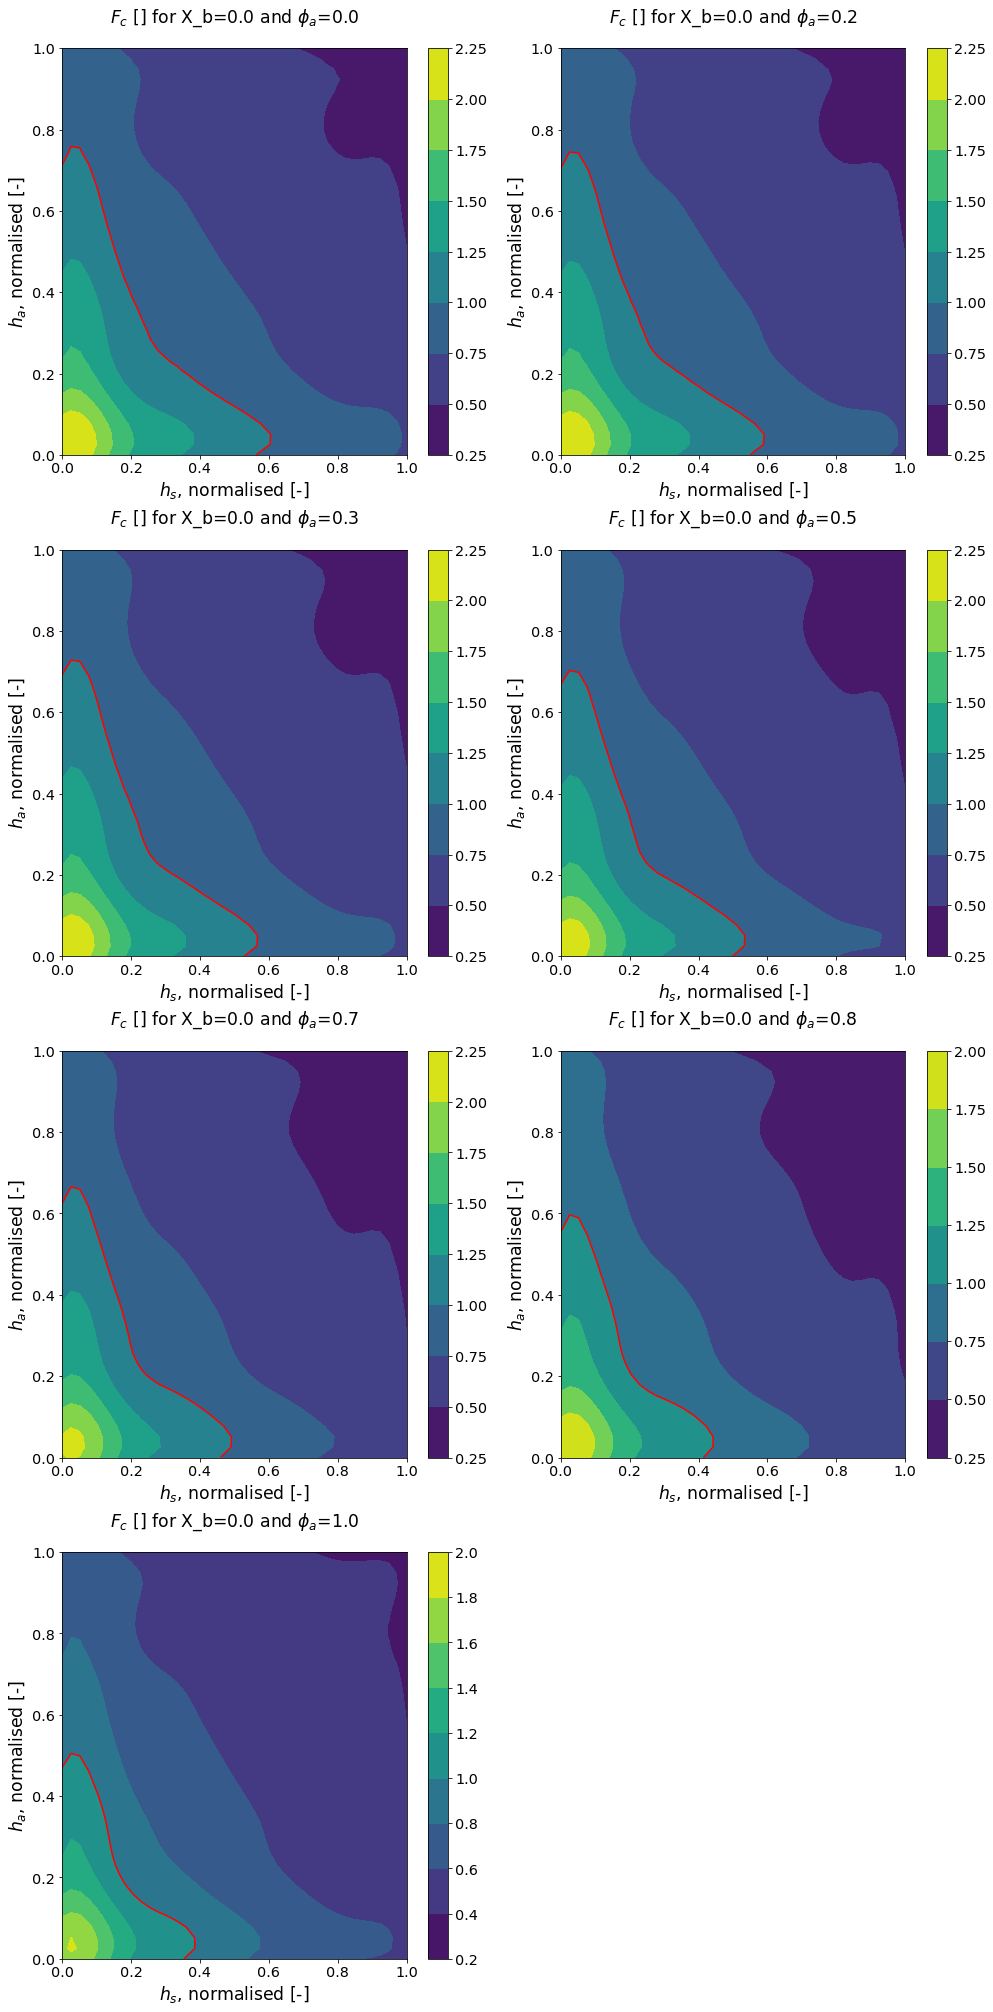

In [10]:
#we plot Fi at fixed values of maximum X_b[ns] and varying the value of phi
plotVaryPhiFixedX_b(XG,YG,ZG,angles,lengths[-1],F_c,'F_c')
#we plot Fi at fixed values of minimum X_b[ns] and varying the value of phi
plotVaryPhiFixedX_b(XG,YG,ZG,angles,lengths[0],F_c,'F_c')

### $D$ visualisation
Bending stiffness

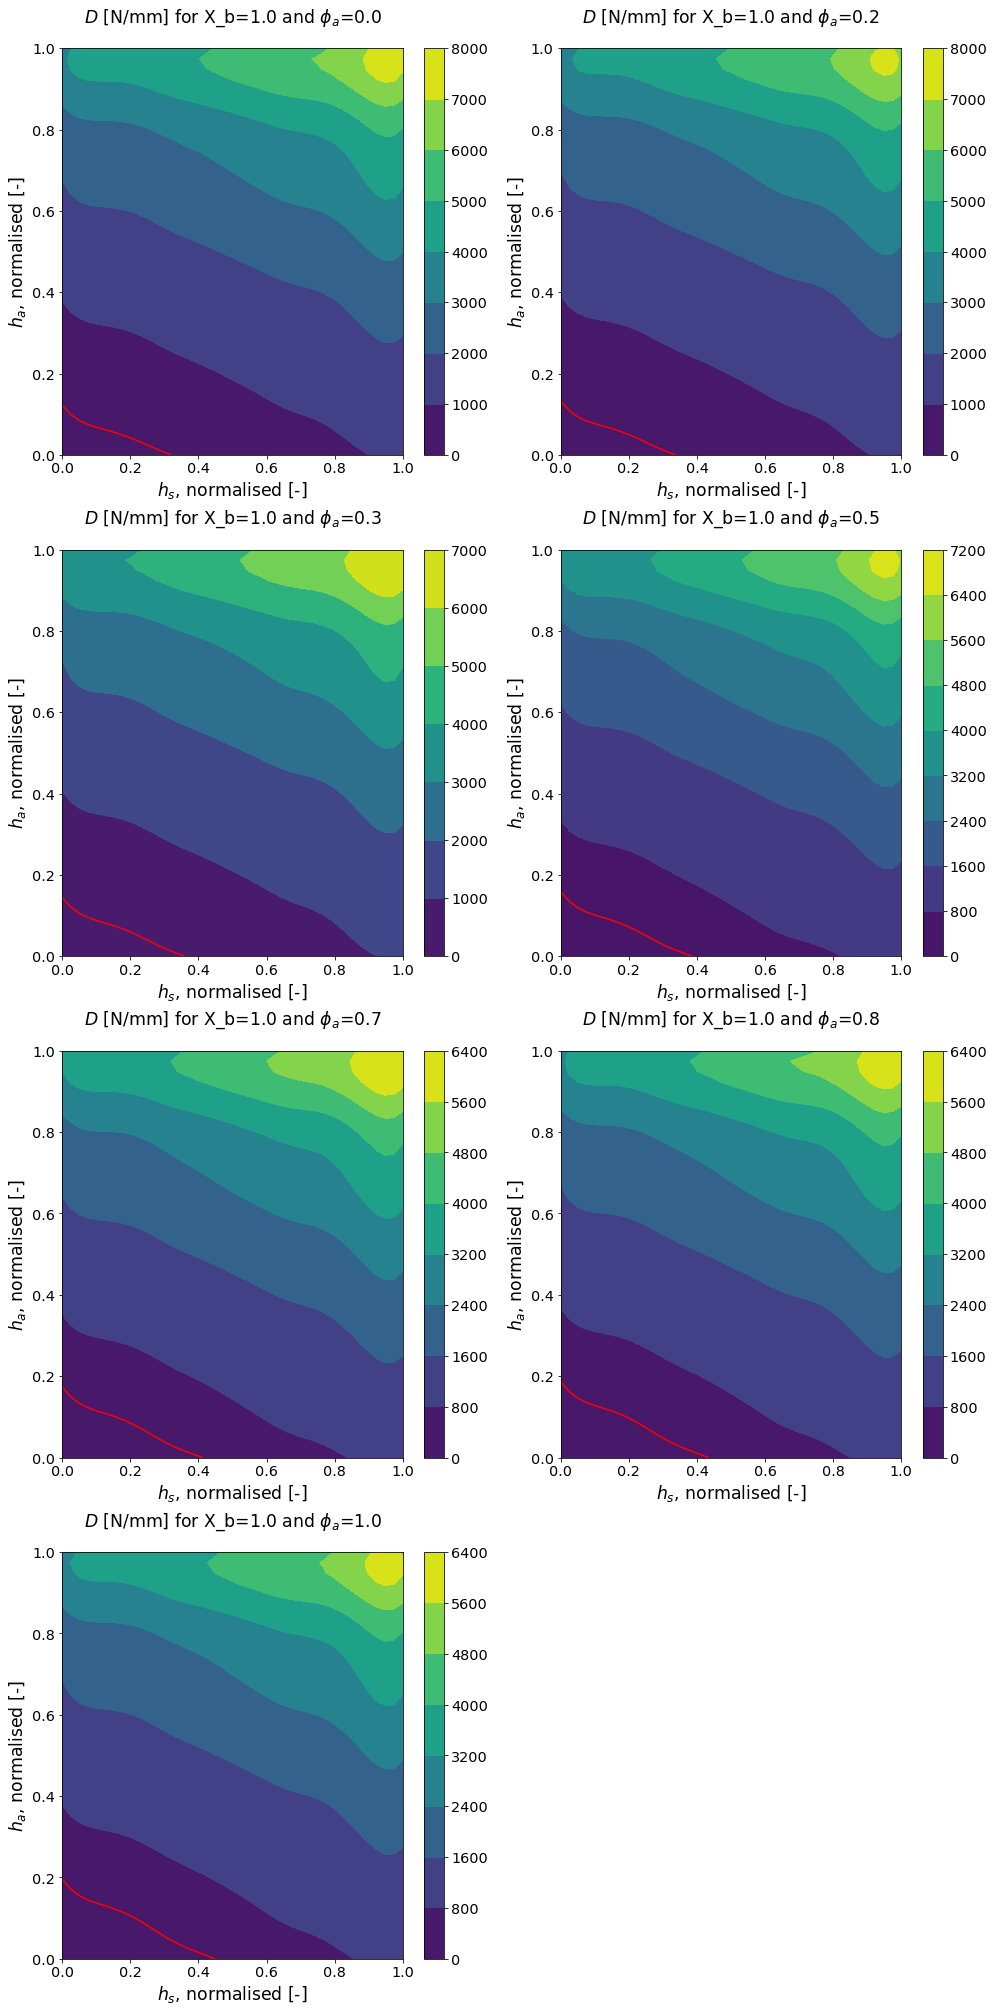

In [11]:
#we plot Fi at fixed values of maximum X_b[ns] and varying the value of phi
plotVaryPhiFixedX_b(XG,YG,ZG,angles,lengths[-1],bstiff,'D',level=490,unit='N/mm')
#we plot Fi at fixed values of minimum X_b[ns] and varying the value of phi
plotVaryPhiFixedX_b(XG,YG,ZG,angles,lengths[0],bstiff,'D',level=490,unit='N/mm')

## Definition of the objective and constraint function

We now define the objective function according to the pyopt framework rules, where both the objective function 
$o(u)=W(u)$ and the constraint function vector $\boldsymbol{g}(u)=[D^*-D,\max(F_s,F_c,F_i)-1]$ are defined in a single function which returns both of them. $D^*$ is the steel bending stiffness (490 N/mm).

In [12]:
def objfunc(u):
    """
    The problem objective function.
    
    Parameters
    ------------
    u: array like
        the design variables vector in the following order: h_s,h_a,phi_a,X_b
        
    Note: one should use the *args, *kwargs mechanism to pass the interpolating functions and parameters,
    and not rely on global variables; however doing so makes pyOpt return an error...
        
    Returns
    -------
    f: float
        the objective function (weight)

    g: array
        a two component array containing the values [ DSTAR-D,max F-1] 

    fail: int
        an evaluation failure index (here we always return 0)

    """
    
    fail = 0
    #DEFINE THE OBJECTIVE FUNCTION
    #we recalculate it rather than using an interpolation of the data, of course
    ts = u[0]*(maxh_s-minh_s)+minh_s#steel thickness
    ta = u[1]*(maxh_a-minh_a)+minh_a#region a thickness==region b thickness
    lb = u[3]*(maxX_b-minX_b)+minX_b#length of region b
    f = RHO_STEEL*np.pi*X_S*((R_i+ts)**2-R_i**2)#steel region
    f += rho*np.pi*X_S*((R_i+ts+ta)**2-(R_i+ts)**2)#region a
    f += rho*np.pi*lb*((R_i+ts+2*ta)**2-(R_i+ts+ta)**2)#region b
    f += rho*np.pi*X_C*((R_i+ts+2*ta+H_C)**2-(R_i+ts+2*ta)**2)#region c
    #DEFINE THE CONSTRAINTS
    g = [0,0]
    g[0] = DSTAR-bstiff(*u)
    g[1] = max(F_s(*u),F_c(*u),F_i(*u))-1
  
    return f, g, fail

Now the problem is solved using the package [pyOpt](http://www.pyopt.org/). See its documentation for details on the syntax used. The problem is solved by using a non-sorting genetic algorithm called NSGAII. Details can be found at the corresponding manual
page at the [pyOpt site](http://www.pyopt.org/reference/optimizers.nsga2.html).

In [13]:
#define the optimization problem.
problem = pyOpt.Optimization('barrel for '+matname, objfunc)
#define the objective function name
problem.addObj('W')
#define the problem variables (of continuos 'c' type)
sf = 0.05#safety factor
for name in ['h_s','h_a','phi_a','X_b']:
    #restrict the actual design space to avoid interpolation glitches
    problem.addVar(name,type='c', lower=0.0+sf, upper=1.0-sf)
#add the inequality type strength constraint
problem.addCon('stiffness', type='i')
#add the stiffnes constraint
problem.addCon('resistance', type='i')
#define the solver, a non-sorting genetic algorithm
solver = pyOpt.pyNSGA2.NSGA2()
#set the solver options
solver.setOption('maxGen',250)
solver.setOption('PrintOut',0)#no output to file
#solve the optimization problem
[fstr, xstr, inform] = solver(problem)
#print the results
print(problem.solution(0))
problem.solution(0).write2file(resfile)


NSGA-II Solution to barrel for sic

        Objective Function: objfunc

    Solution: 
--------------------------------------------------------------------------------
    Total Time:                    9.3039
    Total Function Evaluations:          

    Objectives:
        Name        Value        Optimum
	     W         955.259             0

	Variables (c - continuous, i - integer, d - discrete):
        Name    Type       Value       Lower Bound  Upper Bound
	    h_s       c	      0.693977       5.00e-02     9.50e-01 
	    h_a       c	      0.202618       5.00e-02     9.50e-01 
	   phi_a      c	      0.766192       5.00e-02     9.50e-01 
	    X_b       c	      0.211868       5.00e-02     9.50e-01 

	Constraints (i - inequality, e - equality):
        Name    Type                    Bounds
	 stiffness	  i       -1.00e+21 <= -386.267372 <= 0.00e+00
	 resistance	  i       -1.00e+21 <= -0.000003 <= 0.00e+00

--------------------------------------------------------------------------

In [14]:
#get and print the actual results
hs = xstr[0]*(maxh_s-minh_s)+minh_s
ha = xstr[1]*(maxh_a-minh_a)+minh_a
phia = xstr[2]*(maxphi_a-minphi_a)+minphi_a
Xb = xstr[3]*(maxX_b-minX_b)+minX_b
_,g,_=objfunc(xstr)
outstring='\n'.join(["Results in the actual design space"]+
                    [name+":\t"+"{:.2f}".format(var) for var,name in zip([hs,ha,phia,Xb],['hs','ha','phia','Xb'])]+
                    ["Total weigth:\t"+"{:.2f}".format(fstr[0]),"Bending stiffness:\t"+"{:.2f}".format(DSTAR-g[0]),
                     "Failure index:\t"+"{:.2f}".format(g[1]+1)]
                    )
print outstring
with open(resfile, 'a') as rf:
    rf.write(outstring)

Results in the actual design space
hs:	26.74
ha:	20.10
phia:	44.88
Xb:	2162.72
Total weigth:	955.26
Bending stiffness:	876.27
Failure index:	1.00


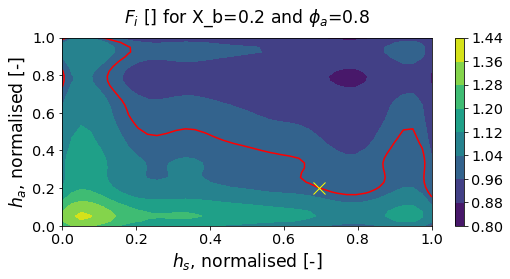

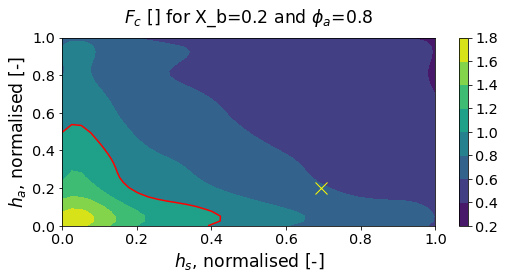

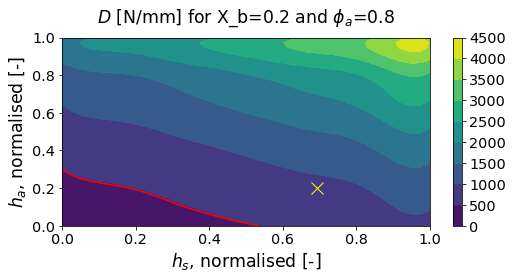

In [15]:
#plot some F_k at the optimal values for X_b, phi_a
plotVaryPhiFixedX_b(XG,YG,ZG,[xstr[2]],xstr[3],F_s,'F_s')
plt.plot(xstr[0], xstr[1],'x',color='yellow',markersize=12)
plotVaryPhiFixedX_b(XG,YG,ZG,[xstr[2]],xstr[3],F_i,'F_i')
plt.plot(xstr[0], xstr[1],'x',color='yellow',markersize=12)
plotVaryPhiFixedX_b(XG,YG,ZG,[xstr[2]],xstr[3],F_c,'F_c')
plt.plot(xstr[0], xstr[1],'x',color='yellow',markersize=12)
plotVaryPhiFixedX_b(XG,YG,ZG,[xstr[2]],xstr[3],bstiff,'D',level=490,unit='N/mm')
plt.plot(xstr[0], xstr[1],'x',color='yellow',markersize=12)

In [16]:
#save some figure
#we must redraw it beacause %matplolib inline backend is dumb as hell
plotVaryPhiFixedX_b(XG,YG,ZG,[xstr[2]],xstr[3],F_i,'F_i')
plt.plot(xstr[0], xstr[1],'x',color='yellow',markersize=12)
plt.annotate('Optimal solution', xy=(xstr[0], xstr[1]), xytext=(0.2, 0.5),color='yellow',fontsize='x-large',
            arrowprops=dict(arrowstyle="->",color='yellow'),
            )
plt.savefig('wrapped_barrel_sic_Fi_optimal.pdf',bbox_inches='tight')